# 1. Load and Preprocessing Data

In [1]:
from keras.datasets import mnist
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [3]:
input_size = x_train.shape[1] * x_train.shape[2]

In [4]:
x_train = np.reshape(x_train, [-1, input_size])
x_test = np.reshape(x_test, [-1, input_size])

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
n_labels = len(np.unique(y_train))

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 2. Define Hyperparameter Set

In [9]:
hidden_units_set = {'min':32,
                    'max':256}
dropout_set = {'min':0.2,
               'max':0.8}

## Fixed Hyperparameters

In [10]:
batch_size = 64
optimizer = 'Adam'
act_fn = 'relu'

# 3. Define functions for Bayesian Optimization

In [11]:
from scipy.stats import norm

def expected_improvement(mean, std, max_val):
	z = (mean - max_val ) / (std + 1e-10)
	return (mean-max_val) * norm.cdf(z) + std * norm.pdf(z)

In [12]:
from mlp import *

def f(x, batch_size = batch_size, optimizer = optimizer, act_fn = act_fn):
  hidden_units = x['hidden_units']
  dropout = x['dropout']
  model = MLP(input_size, n_labels, hidden_units, act_fn, dropout)
  model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])
  model.fit(x_train, y_train, epochs = 10, batch_size=batch_size, verbose = 0)
  loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)

  return acc

# 4. Searching

## Initialization

In [13]:
init_n = 5
sample_n = 10

In [14]:
import pandas as pd
x = pd.DataFrame({})
x['hidden_units'] = np.random.randint(hidden_units_set['min'],hidden_units_set['max'],init_n)
x['dropout'] = np.random.randint(dropout_set['min']*100,dropout_set['max']*100, init_n) / 100
print(x)

   hidden_units  dropout
0           110     0.59
1            40     0.74
2            74     0.27
3           126     0.20
4           120     0.62


In [15]:
y = np.array([f(x.iloc[i,:]) for i in range(init_n)])

157/157 [==============================] - 0s 2ms/step - loss: 0.1249 - accuracy: 0.9647


## Find Optimal Hyaperparameter

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
regressor = GaussianProcessRegressor()
n_epoch = 30

In [17]:
for _ in range(n_epoch):
  # fit regressor
  x_fit = x.copy()
  x_fit['hidden_units'] = x_fit['hidden_units']/hidden_units_set['max']
  regressor.fit(x_fit,y)

  # make sample hyperparameter sets
  x_sample = pd.DataFrame({})
  x_sample['hidden_units'] = np.random.randint(hidden_units_set['min'],hidden_units_set['max'],sample_n)/hidden_units_set['max']
  x_sample['dropout'] = np.random.randint(dropout_set['min']*100,dropout_set['max']*100, sample_n) / 100
  
  # select sample and calculate the results
  m, std = regressor.predict(x_sample,return_std=True)

  acq = [expected_improvement(m[i],std[i],y.max()) for i in range(len(m))]
  x_sample = x_sample.iloc[np.argmax(acq),:]
  x_sample['hidden_units'] = x_sample['hidden_units'] * hidden_units_set['max']

  y_new = f(x_sample)

  # append search results
  x = x.append(x_sample)
  y = np.append(y,y_new)


157/157 [==============================] - 0s 1ms/step - loss: 0.1240 - accuracy: 0.9639


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 3ms/step - loss: 0.0639 - accuracy: 0.9839


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9811


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 2ms/step - loss: 0.2509 - accuracy: 0.9322


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9750


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 3ms/step - loss: 0.0697 - accuracy: 0.9797


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.1076 - accuracy: 0.9695


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 3ms/step - loss: 0.0678 - accuracy: 0.9819


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.9801


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0708 - accuracy: 0.9798


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.0599 - accuracy: 0.9820


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 1ms/step - loss: 0.1233 - accuracy: 0.9636


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 2ms/step - loss: 0.0765 - accuracy: 0.9764


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 0s 2ms/step - loss: 0.1278 - accuracy: 0.9634


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


157/157 [==============================] - 1s 3ms/step - loss: 0.0834 - accuracy: 0.9754


# 5. Results

In [20]:
df = x.copy()
df['test_acc'] = y
df.index = range(np.shape(df)[0])
print(df)

    hidden_units  dropout  test_acc
0          110.0     0.59    0.9625
1           40.0     0.74    0.8810
2           74.0     0.27    0.9751
3          126.0     0.20    0.9799
4          120.0     0.62    0.9647
5          255.0     0.70    0.9703
6          241.0     0.31    0.9787
7          212.0     0.50    0.9783
8          251.0     0.38    0.9831
9          187.0     0.41    0.9792
10         124.0     0.27    0.9787
11         220.0     0.35    0.9785
12         190.0     0.22    0.9815
13         204.0     0.75    0.9599
14         255.0     0.49    0.9808
15          48.0     0.31    0.9639
16         210.0     0.20    0.9810
17         252.0     0.78    0.9609
18         247.0     0.32    0.9839
19         174.0     0.33    0.9811
20         100.0     0.76    0.9322
21         200.0     0.57    0.9750
22         250.0     0.44    0.9797
23         161.0     0.66    0.9695
24         247.0     0.25    0.9819
25         168.0     0.26    0.9801
26         142.0     0.26   

In [21]:
df.describe()

,hidden_units,dropout,test_acc
count,35.000000,35.000000,35.000000
mean,174.428571,0.434571,0.971297
std,67.966378,0.185272,0.018750
min,40.000000,0.200000,0.881000
25%,125.000000,0.270000,0.967100
50%,190.000000,0.390000,0.978500
75%,244.000000,0.585000,0.980450
max,255.000000,0.780000,0.983900


## Plot accuracy

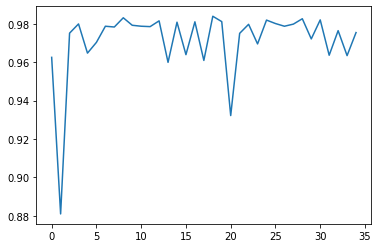

In [22]:
import matplotlib.pyplot as plt

plt.plot(df['test_acc'])